# Import libraries

In [1]:
from typing import Optional
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Read metadata

In [2]:
metadata_path = Path("../data/RB_metadata.csv")
rb_magnet_metadata = pd.read_csv(metadata_path, index_col=False)
rb_magnet_metadata

,Circuit,Magnet,Position,B1_aperture,Diode_type,Correctors,EE place,#Electric_EE,#Electric_circuit,Cryostat,...,Dcum2,QPS Crate,QPS Board,#Segment,phys_pos,Name,R_1,R_2,RRR_1,RRR_2
0,RB.A12,MB.A8R1,276.7340,EXT,R,A,EVEN,1,78,LBARE.8R1,...,268.9040,B8R1,0,79,1,A8R1,1.80,1.85,95.650088,94.103943
1,RB.A12,MB.B8R1,292.3940,EXT,R,B,ODD,77,77,LBBRF.8R1,...,284.5640,B9R1,0,77,2,B8R1,1.67,1.85,100.314516,94.103943
2,RB.A12,MB.A9R1,315.7990,EXT,R,A,EVEN,2,79,LBARE.9R1,...,307.9690,B8R1,1,80,3,A9R1,1.75,1.85,97.936878,94.103943
3,RB.A12,MB.B9R1,331.4590,EXT,R,B,ODD,76,76,LBBRG.9R1,...,323.6290,B11R1,2,76,4,B9R1,1.67,1.77,100.314516,97.371760
4,RB.A12,MB.A10R1,356.2640,EXT,R,A,EVEN,3,80,LBARE.10R1,...,348.4340,B10R1,0,81,5,A10R1,1.67,1.67,100.314516,100.314516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,RB.A81,MB.A10L1,26302.6192,INT,L,B,ODD,75,75,LBBLG.10L1,...,26294.7892,B10L1,1,75,150,A10L1,2.53,3.13,78.314002,70.353447
1228,RB.A81,MB.B9L1,26327.4242,INT,L,A,EVEN,2,79,LBALE.9L1,...,26319.5942,B9L1,1,80,151,B9L1,3.25,3.70,68.099268,54.735949
1229,RB.A81,MB.A9L1,26343.0842,INT,L,B,ODD,76,76,LBBLF.9L1,...,26335.2542,B10L1,2,76,152,A9L1,3.09,1.75,70.748254,99.628927
1230,RB.A81,MB.B8L1,26366.4892,INT,L,A,EVEN,1,78,LBALE.8L1,...,26358.6592,B9L1,0,79,153,B8L1,2.43,2.43,79.915648,79.899869


# Define position map

In [3]:
def map_position_index(pos_map, origin="El. Position", to="Phys. Position", filt: Optional[dict]=None, old_index: Optional[np.array]=None):
    """
    function maps origin index to new index. E.g. RB.A12 origin="El. Position"=[0, ..., 154] -> to="Phys. Position"=[78, ..., 1]
    :param pos_map: lookup table to map positions
    :param origin: origin index name with which the data is sorted, E.g. "El. Position"
    :param to: origin index name with which the data is sorted, E.g. "Phys. Position"
    :return: electrical position array index
    """
    if old_index is None:
        old_index = np.arange(0,154)
    pos_map_subset = pd_dict_filt(pos_map, filt)
    new_index = pos_map_subset.sort_values(by=to)[origin].values #  & (pos_map.quench_pos == quench_pos)
    not_nan_values = pos_map_subset.sort_values(by=to)[to].values >= 0
    return new_index[old_index][not_nan_values[old_index]].astype(int)


def center_array(array, center_index):
    """
    shifts array to the right, such that center_index is in the middle. Padding with nan values
    :param array: data to center
    :param circuit: index indicating the middle of the array
    :return: centered array
    """
    mask = np.zeros(((array.shape[0] * 2, ) + array.shape[1:])) * np.nan # mask in both directions necessary
    mask[:len(array)] = array

    roll = len(array) - center_index
    centered_array = np.roll(mask, roll, axis=0)
    
    return centered_array

def split_main_mirror(matrix, center):
    im_len = int(len(matrix)/2)
    if center > len(matrix) / 2:
        # quench is in second half
        matrix_main = matrix[im_len:]
        matrix_mirror  = matrix[:im_len]
        
        center_main = center - im_len
        center_mirror = len(matrix) - center

    else:
        # center is in first half
        matrix_main = matrix[:im_len]
        matrix_mirror  = matrix[im_len:]
        
        center_main = center 
        center_mirror = im_len - center
    
    main_centered = center_array(matrix_main, center_main)
    mirror_centered = center_array(matrix_mirror, center_mirror)
    return main_centered, mirror_centered

def nanargsort(array: np.array) -> np.array:
    """
    argsort with dropna
    :param array: array to sort
    :return: index of sorted array without nan
    """
    return np.argsort(array)[(np.sort(array) >=0)]


def pd_dict_filt(df, filt):
    """
    filters pandas DataFrame by dictonary
    :param df: DataFrame to filer
    :param filt: dict with key columns and args values, equal to df[df[key]== values]
    :return: filtered DataFrame
    """
    if filt is None:
        return df
    else:
        bool_list = [(df[k]==v).to_list() for k, v in filt.items()]
        return df[np.sum(bool_list, axis=0) == len(bool_list)]

In [4]:
pos_map = rb_magnet_metadata[["Circuit", "Magnet", "#Electric_circuit", "phys_pos"]].rename(columns = {"#Electric_circuit": "El. Position", "phys_pos": "Phys. Position"}) #.sort_values(by=["circuit","El. Position"])

# python index starts with 0
pos_map[["El. Position", "Phys. Position"]] = pos_map[["El. Position", "Phys. Position"]] - 1

In [5]:
# for each circuit get index to sort by
phys_pos_index_odd = pos_map[pos_map.Circuit=='RB.A12']["Phys. Position"].values 
phys_pos_index_even_in_odd = pos_map[pos_map.Circuit=='RB.A12']["Phys. Position"].values[::-1] 
phys_pos_index_even = np.array([[d, c] for c, d in zip(phys_pos_index_even_in_odd[::2], phys_pos_index_even_in_odd[1::2])]).flatten()

for circuit in pos_map["Circuit"].unique():
    if  int(circuit[4]) % 2 == 0:
        pc_dist_index = phys_pos_index_even
    else: 
        pc_dist_index = phys_pos_index_even_in_odd 
        
    #TODO: only right for odd index:
    pos_map.loc[pos_map["Circuit"]==circuit, "Phys. Dist. to PC"] = pc_dist_index
    pos_map.loc[pos_map["Circuit"]==circuit, "Phys. Position ODD"] = phys_pos_index_odd
    pos_map.loc[pos_map["Circuit"]==circuit, "Phys. Position EVEN"] = phys_pos_index_even

In [6]:
# inflate df, add quench position. Size of df gets (8*154)*154
df_list = []
for q in pos_map[pos_map.Circuit=='RB.A12']["Phys. Position"].values:
    for circuit in pos_map["Circuit"].unique():
        el_quench_pos = map_position_index(pos_map, old_index=[q], origin="El. Position", to="Phys. Position", filt={"Circuit":circuit})[0]
        pos_map.loc[pos_map["Circuit"]==circuit, "El. Quench Position"] = el_quench_pos
    pos_map["Phys. Quench Position"] = q
    df_list.append(pos_map.copy())
    
pos_map_q = pd.concat(df_list)

In [7]:
# add Distances to Quench 
for circuit in pos_map["Circuit"].unique():
    for q in np.arange(154):
        el_quench_pos = map_position_index(pos_map, old_index=[q], origin="El. Position", to="Phys. Position", filt={"Circuit":circuit})[0]
        
        phys_bool = (pos_map_q["Circuit"]== circuit) & (pos_map_q["Phys. Quench Position"]==q)
        df = pos_map_q[phys_bool] 
        pos_map_q.loc[phys_bool, "Phys. Dist. to Quench"] = nanargsort(center_array(df["Phys. Position"].values, q))

In [8]:
# add Distances to Quench el. Position
# switch to el. Position sort
pos_map_q = pos_map_q.sort_values(by="El. Position")
for circuit in pos_map["Circuit"].unique():
    for q in np.arange(154):       
        el_bool = ((pos_map_q["Circuit"]== circuit) & (pos_map_q["El. Quench Position"]==q)).values
        df = pos_map_q[el_bool] 
        
        
        main_index, mirror_index = split_main_mirror(df["El. Position"].values, q)
        el_bool_full_main = el_bool.copy()
        el_bool_main = el_bool_full_main[el_bool]
        el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
        el_bool_full_main[el_bool] = el_bool_main
        
        el_bool_full_mirror = el_bool.copy()
        el_bool_mirror = el_bool_full_mirror[el_bool]
        el_bool_mirror[main_index[main_index >=0].astype(int)] = False
        el_bool_full_mirror[el_bool] = el_bool_mirror

        pos_map_q.loc[el_bool_full_main, "El. Dist. to Quench Main"] = nanargsort(main_index)
        pos_map_q.loc[el_bool_full_mirror,  "El. Dist. to Quench Mirror"] = nanargsort(mirror_index)

In [9]:
# convert float to int
nan_columns = pos_map_q.isna().any(axis=0)
int_columns = pos_map_q.loc[:,~nan_columns].drop(columns=['Circuit', 'Magnet']).columns
pos_map_q[int_columns] = pos_map_q[int_columns].astype(int)

In [10]:
filt = {"Circuit":"RB.A12", "El. Quench Position": 0} 
pd_dict_filt(pos_map_q, filt).sort_values(by="El. Position").reset_index(drop=True).T 

,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,150,151,152,153
Circuit,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,...,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12
Magnet,MB.A8L2,MB.A9L2,MB.A10L2,MB.A11L2,MB.A12L2,MB.C12L2,MB.B13L2,MB.A14L2,MB.C14L2,MB.B15L2,...,MB.C15L2,MB.A15L2,MB.B14L2,MB.C13L2,MB.A13L2,MB.B12L2,MB.B11L2,MB.B10L2,MB.B9L2,MB.B8L2
El. Position,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,150,151,152,153
Phys. Position,153,151,149,147,145,143,141,139,137,135,...,134,136,138,140,142,144,146,148,150,152
Phys. Dist. to PC,0,2,4,6,8,10,12,14,16,18,...,19,17,15,13,11,9,7,5,3,1
Phys. Position ODD,153,151,149,147,145,143,141,139,137,135,...,134,136,138,140,142,144,146,148,150,152
Phys. Position EVEN,1,3,5,7,9,11,13,15,17,19,...,18,16,14,12,10,8,6,4,2,0
El. Quench Position,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Phys. Quench Position,153,153,153,153,153,153,153,153,153,153,...,153,153,153,153,153,153,153,153,153,153
Phys. Dist. to Quench,154,152,150,148,146,144,142,140,138,136,...,135,137,139,141,143,145,147,149,151,153


In [11]:
pos_map_q.reset_index(drop=True).to_csv("..\data\circuit_sort.csv",index=False)

# Map index

In [12]:
filt = {"Circuit":"RB.A12", "El. Quench Position": 0} 
phys_dist = map_position_index(pos_map_q, origin="El. Position", to= 'Phys. Dist. to Quench', filt=filt)
phys_dist

array([ 77,  76,  78,  75,  79,  74,  80,  73,  81,  72,  82,  71,  83,
        70,  84,  69,  85,  68,  86,  67,  87,  66,  88,  65,  89,  64,
        90,  63,  91,  62,  92,  61,  93,  60,  94,  59,  95,  58,  96,
        57,  97,  56,  98,  55,  99,  54, 100,  53, 101,  52, 102,  51,
       103,  50, 104,  49, 105,  48, 106,  47, 107,  46, 108,  45, 109,
        44, 110,  43, 111,  42, 112,  41, 113,  40, 114,  39, 115,  38,
       116,  37, 117,  36, 118,  35, 119,  34, 120,  33, 121,  32, 122,
        31, 123,  30, 124,  29, 125,  28, 126,  27, 127,  26, 128,  25,
       129,  24, 130,  23, 131,  22, 132,  21, 133,  20, 134,  19, 135,
        18, 136,  17, 137,  16, 138,  15, 139,  14, 140,  13, 141,  12,
       142,  11, 143,  10, 144,   9, 145,   8, 146,   7, 147,   6, 148,
         5, 149,   4, 150,   3, 151,   2, 152,   1, 153,   0])

# Test Indexes

In [11]:
pos_map_q = pd.read_csv("..\data\circuit_sort.csv")

In [12]:
import sys
from pathlib import Path
sys.path.insert(0,'..')
import glob

from src.dataset import load_dataset
from src.datasets.rb_fpa_prim_quench_ee_plateau import RBFPAPrimQuenchEEPlateau
from src.utils.frequency_utils import get_fft_of_DataArray
from src.visualisation.fft_visualisation import plot_circuit_frequencies

In [13]:
dataset_path_1EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_prim_ee_plateau_dataset")
dataset_creator_1EE = RBFPAPrimQuenchEEPlateau()
fpa_identifiers = ['RB_RB.A78_1615271973700000000']
dataset_1EE = dataset_creator_1EE.load_dataset(fpa_identifiers=fpa_identifiers,
                                       dataset_path=dataset_path_1EE,
                                       drop_data_vars=['simulation', 'el_position_feature', 'event_feature'])


max_freq = 360
dataset_1EE_fft = get_fft_of_DataArray(data=dataset_1EE.data, cutoff_frequency=max_freq)

In [14]:
circuit = str(fpa_identifiers[0]).split('_')[1]
data = dataset_1EE_fft[{'event': 0}].data
frequency = dataset_1EE_fft[{'event': 0}].frequency

sort_columns = ['El. Position', 'Phys. Position', 'Phys. Position ODD', 'Phys. Position EVEN', 'Phys. Dist. to PC', 'Phys. Dist. to Quench', 'El. Dist. to Quench Main', 'El. Dist. to Quench Mirror']

#sort_columns = ['Phys. Dist. to Quench', 'El. Dist. to Quench Main']

el_quench_pos = 109
filt = {"Circuit":circuit, "El. Quench Position": el_quench_pos}

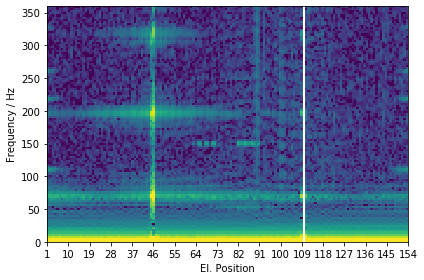

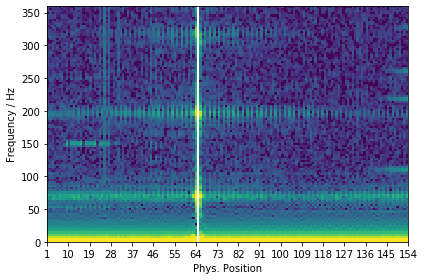

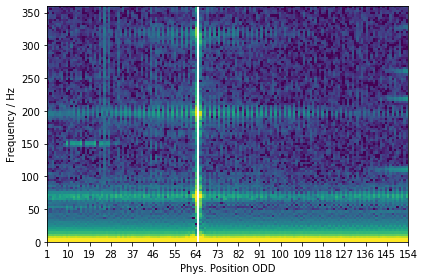

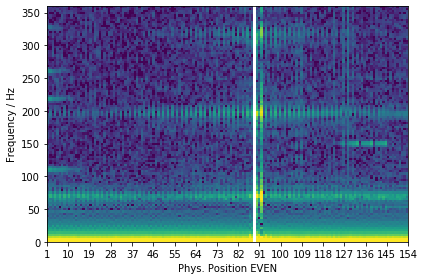

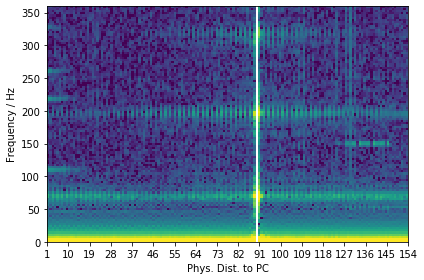

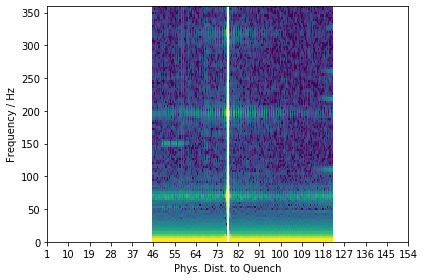

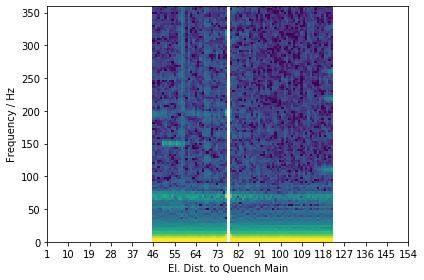

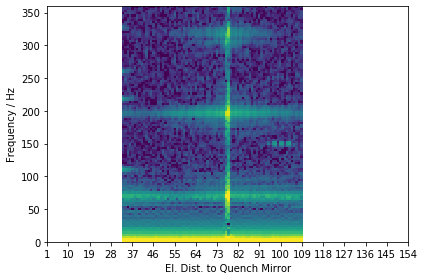

In [17]:
for target in sort_columns:
    
    pos_map_subset = pd_dict_filt(pos_map_q, filt)
    index = map_position_index(pos_map_subset, origin="El. Position", to=target)
    max_index = int(pos_map_q[target].max())
    target_index = map_position_index(pos_map_subset, origin=target, to=target)
    data_plot = np.zeros((max_index+1, data.shape[-1]))

    data_plot[target_index] = data[index]
        
    fig, ax = plt.subplots()
    plot_circuit_frequencies(ax, data_plot, frequency)  
    
    ax.set_xlabel(target)
    plt.show()
